In [3]:
import pandas as pd

import pymc3 as pm

import matplotlib.pyplot as plt

import arviz as az

from sklearn.preprocessing import StandardScaler

In [5]:
df = pd.read_csv(r'data.csv')
print(df)

     Unnamed: 0  ppvt  educ_cat  momage
0             1   120         2      21
1             2    89         1      17
2             3    78         2      19
3             4    42         1      20
4             5   115         4      26
..          ...   ...       ...     ...
395         396    87         3      21
396         397    69         2      20
397         398    80         1      25
398         399    98         1      18
399         400    81         2      22

[400 rows x 4 columns]


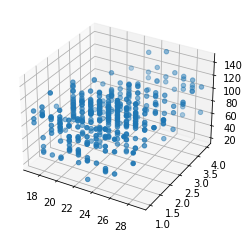

In [7]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df['momage'], df['educ_cat'], df['ppvt'])
plt.show()

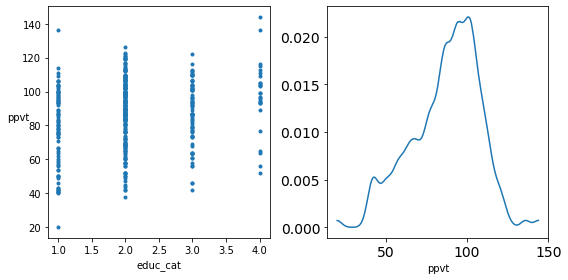

In [8]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(df['educ_cat'], df['ppvt'], 'C0.')
ax[0].set_xlabel('educ_cat')
ax[0].set_ylabel('ppvt', rotation=0)
az.plot_kde(df['ppvt'], ax=ax[1])
ax[1].set_xlabel('ppvt')
plt.tight_layout()

In [9]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=df['ppvt'].mean(), sd=10*df['ppvt'].std())
    β = pm.Normal('β', mu=0, sd=1)
    ε = pm.HalfCauchy('ε', 7)
    μ = pm.Deterministic('μ', α + β * df['educ_cat'])
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=df['ppvt'])
    idata_g = pm.sample(2000, tune=6000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ε, β, α]


Sampling 4 chains for 6_000 tune and 2_000 draw iterations (24_000 + 8_000 draws total) took 20 seconds.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ε'}>,
        <AxesSubplot:title={'center':'ε'}>]], dtype=object)

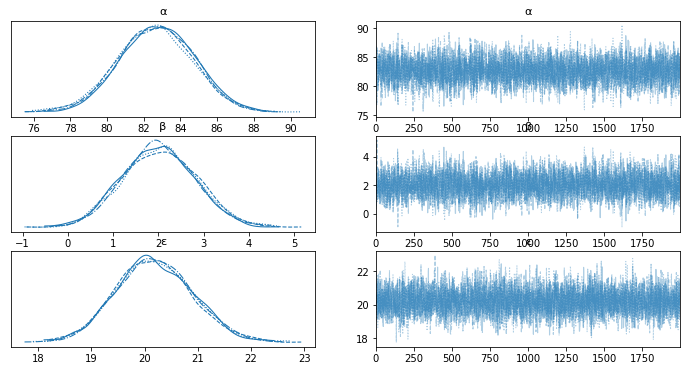

In [10]:
az.plot_trace(idata_g, var_names=['α', 'β', 'ε'])

/home/ina/.local/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/ina/.local/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'ppvt')

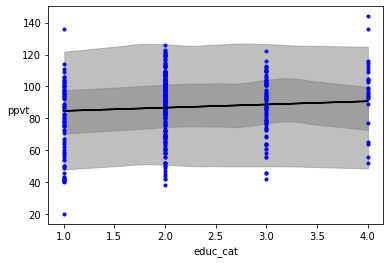

In [11]:
posterior_g = idata_g.posterior.stack(samples={"chain", "draw"})
alpha_m = posterior_g['α'].mean().item()
beta_m = posterior_g['β'].mean().item()
draws = range(0, posterior_g.samples.size, 10)

ppc = pm.sample_posterior_predictive(idata_g, samples=2000, model=model_g)
plt.plot(df['educ_cat'], df['ppvt'], 'b.')
plt.plot(df['educ_cat'], alpha_m + beta_m * df['educ_cat'], c='k',
label=f"y = {alpha_m:.2f} + {beta_m:.2f} * df['educ_cat']")
az.plot_hdi(df['educ_cat'], ppc['y_pred'], hdi_prob=0.5, color='gray')
az.plot_hdi(df['educ_cat'], ppc['y_pred'], color='gray')
plt.xlabel('educ_cat')
plt.ylabel('ppvt', rotation=0)

In [ ]:
# aici de asemenea, avem o mica creste in ppvt odata ce educ_cat e mai mare
# chiar daca nu e o diferenta enorma

In [18]:
scaler = StandardScaler()
standardized_data = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
print(standardized_data)

     Unnamed: 0      ppvt  educ_cat    momage
0     -1.727726  1.619802 -0.138494 -0.666358
1     -1.719066  0.101276 -1.369555 -2.155427
2     -1.710406 -0.437556 -0.138494 -1.410893
3     -1.701745 -2.201006 -1.369555 -1.038625
4     -1.693085  1.374879  2.323627  1.194978
..          ...       ...       ...       ...
395    1.693085  0.003306  1.092566 -0.666358
396    1.701745 -0.878419 -0.138494 -1.038625
397    1.710406 -0.339587 -1.369555  0.822710
398    1.719066  0.542138 -1.369555 -1.783160
399    1.727726 -0.290602 -0.138494 -0.294091

[400 rows x 4 columns]


In [21]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ε = pm.HalfCauchy('ε', 5)
    μ = pm.Deterministic('μ', α + β * standardized_data['educ_cat'])
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=standardized_data['ppvt'])
    idata_g = pm.sample(2000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ε, β, α]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 7 seconds.


In [38]:
posterior_g = idata_g.posterior.stack(samples={"chain", "draw"})
alpha_m = posterior_g['α'].mean().item()
beta_m = posterior_g['β'].mean().item()
draws = range(0, posterior_g.samples.size, 10)

/home/ina/.local/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/ina/.local/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'ppvt')

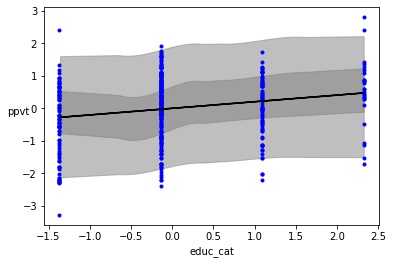

In [32]:
ppc = pm.sample_posterior_predictive(idata_g, samples=2000, model=model_g)
plt.plot(standardized_data['educ_cat'], standardized_data['ppvt'], 'b.')
plt.plot(standardized_data['educ_cat'], alpha_m + beta_m * standardized_data['educ_cat'], c='k',
label=f"y = {alpha_m:.2f} + {beta_m:.2f} * standardized_data['educ_cat']")
az.plot_hdi(standardized_data['educ_cat'], ppc['y_pred'], hdi_prob=0.5, color='gray')
az.plot_hdi(standardized_data['educ_cat'], ppc['y_pred'], color='gray')
plt.xlabel('educ_cat')
plt.ylabel('ppvt', rotation=0)